In [12]:
import torchaudio

audio_base_path = '/root/data/AudioMNIST/data'
audio_path = audio_base_path + '/01/0_01_0.wav'
waveform, sample_rate = torchaudio.load(audio_path)
waveform.shape, sample_rate

(torch.Size([1, 35877]), 48000)

In [13]:
import json 

meta_file_path = audio_base_path + '/audioMNIST_meta.txt'
with open(meta_file_path) as f:
    data = json.load(f)
data['01']

{'accent': 'german',
 'age': 30,
 'gender': 'male',
 'native speaker': 'no',
 'origin': 'Europe, Germany, Wuerzburg',
 'recordingdate': '17-06-22-11-04-28',
 'recordingroom': 'Kino'}

In [14]:
from lib.datasets import load_datapath

train_datapath = load_datapath(root_path=audio_base_path, filter_fn=lambda x: x['accent'] == 'German')
test_datapath = load_datapath(root_path=audio_base_path, filter_fn=lambda x: x['accent'] != 'German')
len(train_datapath), len(test_datapath)

(20000, 10000)

In [15]:
from lib.datasets import AudioMINST

train_minst = AudioMINST(data_paths=train_datapath)
train_minst[0]

((tensor([[0.0003, 0.0003, 0.0004,  ..., 0.0005, 0.0005, 0.0004]]), 48000), 0)

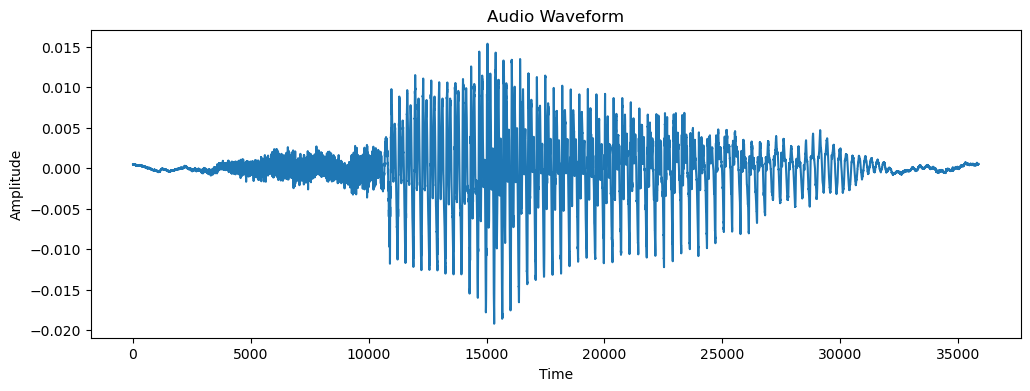

In [16]:
from lib.wavUtils import display_wavform
display_wavform(waveform=waveform)

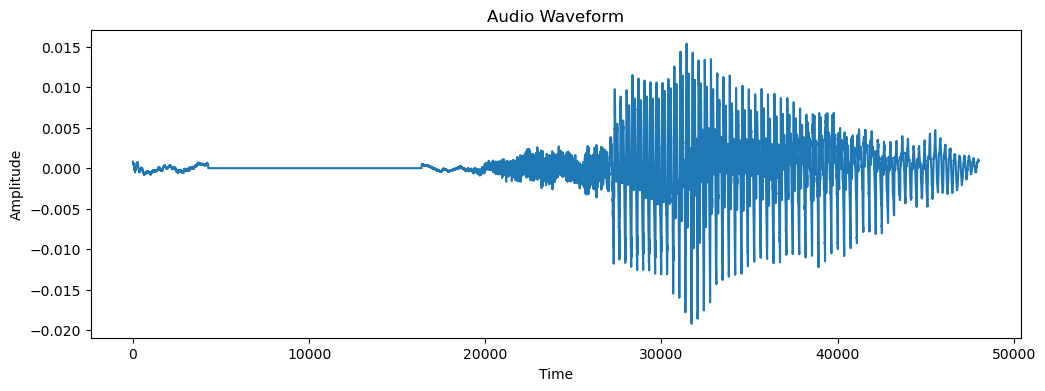

In [17]:
import torchaudio.transforms as transforms
from lib.wavUtils import Components, pad_trunc, time_shift

train_transforms = Components(transforms=[
    pad_trunc(max_ms=1000, sample_rate=48000),
    time_shift(shift_limit=.4)
])
waveform = train_transforms(waveform)
display_wavform(waveform=waveform)

/root/miniconda3/envs/my-audio/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


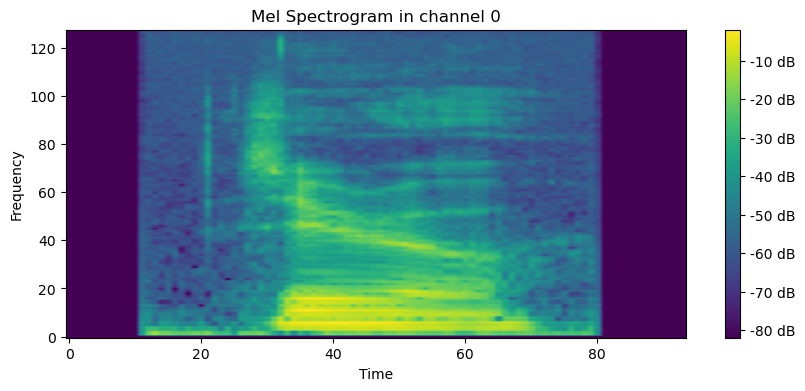

In [18]:
from lib.wavUtils import display_spectro_gram
(waveform, sample_rate), label = train_minst[0]
train_transforms = Components(transforms=[
    pad_trunc(max_ms=1000, sample_rate=48000),
    transforms.MelSpectrogram(sample_rate=48000, n_fft=1024, n_mels=128),
    transforms.AmplitudeToDB(top_db=80)
])

waveform = train_transforms(waveform)
display_spectro_gram(waveform=waveform)

In [19]:
waveform.shape

torch.Size([1, 128, 94])

In [20]:
from torch.utils.data import DataLoader

sample_rate = 48000

train_transforms = Components(transforms=[
    pad_trunc(max_ms=1000, sample_rate=sample_rate),
    time_shift(shift_limit=.1),
    transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, n_mels=64),
    transforms.AmplitudeToDB(top_db=80),
    transforms.FrequencyMasking(freq_mask_param=.1),
    transforms.TimeMasking(time_mask_param=.1)
])
train_minst = AudioMINST(data_paths=train_datapath, data_trainsforms=train_transforms, include_rate=False)
train_dataload = DataLoader(dataset=train_minst, batch_size=64, shuffle=True, drop_last=False)
len(train_dataload)

313

In [21]:
waveforms, labels = next(iter(train_dataload))
waveform.shape, labels.shape

(torch.Size([1, 128, 94]), torch.Size([64]))

In [22]:
from lib.models import WavClassifier
model = WavClassifier(class_num=10, c1_in_channels=1)

model(waveforms).shape

torch.Size([64, 10])